# Ocular Image Disease Detection - Pipeline & Modeling
This project is handling image based data involving the human eye. These images are taken through a method called fundus photography, where an optomotrist is able to take an image of the inside of the human eyeball. The primary objective is to use this dataset to make classifications of ocular disease and impairments. This image dataset also comes along with a csv file that holds the diagnosis of each image that will allow for a machine learning model to be trained and tested. To analyze these images an ensemble model of two Convolutional Neural Networks will be used.

CLassification Numbering

0 - Abnormal

1 - AMD (Age Macular Degeneration)

2 - Cataract

3 - Glaucoma

4 - Hypertension

5 - Myopia

6 - Normal

In [1]:
# Packges
import numpy as np
import os # File Navigation for Directory
import cv2 # OpenCV
import imghdr # Handles image directories
import copy # Copying images
from matplotlib import pyplot as plt

### Building a pipeline

In [2]:
import tensorflow as tf# To build a data pipeline, with tf.data.Dataset API
import keras 
tf.config.experimental.list_physical_devices('CPU') # CPU is good

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
tf.test.gpu_device_name() # My GPU is not being connecting... This is a major issue.

''

I can't properly run a my model due to my GPU acting up suddenly, this will cause a serious delay in my web-based User Interface development when its missing it's main pillar. My Streamlit web app also requires me to transfer my gpu processing for my deep learning model in an .h5 file. I am lost till I find a new GPU.

In [85]:
# Black space should be trimmed before setting standardiation of image size.
class_imgs = 'C:\\Users\\David\\OneDrive\\Documents\\GitHub\\Capstone_Project\\Training_Images'
data = tf.keras.utils.image_dataset_from_directory(class_imgs,batch_size=32,image_size=(256,256))
data_iterator = data.as_numpy_iterator() # Converting into numpy format to allow data access
batch = data_iterator.next()

Found 1255 files belonging to 7 classes.


In [86]:
batch[0].max() # Confirming shape.

255.0

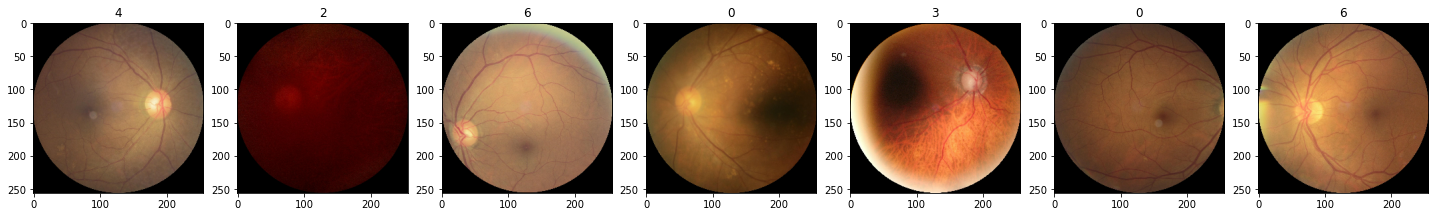

In [87]:
fig, ax = plt.subplots(ncols=7,figsize=(25,25))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

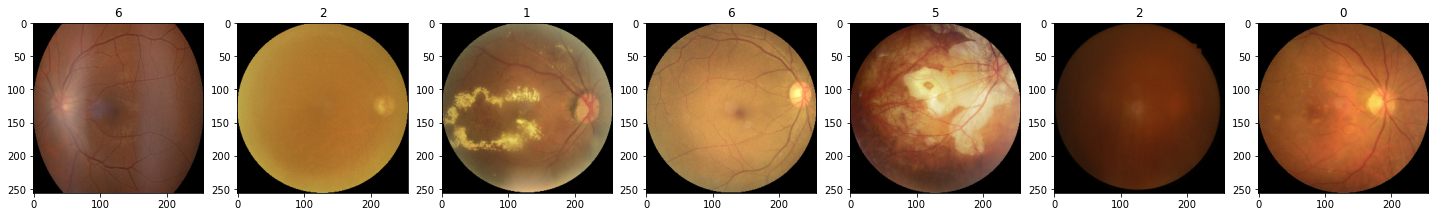

In [88]:
batch = data_iterator.next() # Batch iteration success!
fig, ax = plt.subplots(ncols=7,figsize=(25,25))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

At the top of each image, there is a classificaiton number from 0 to 7

### Preprocessing the Data Pipeline
Scaling image values from 0 to 255 to a range of 0 to 1, this will allow for the deep learning model to generalize faster. The data has also already been split into training and testing datasets within the files.

In [89]:
scale = batch[0]/255
print("Min value:",scale.min())
print("Max value:",scale.max())

Min value: 0.0
Max value: 1.0


In [90]:
data = data.map(lambda x,y: (x/255,y)) # Data Transformation x -> images, y -< Target variable

In [91]:
data.as_numpy_iterator().next()[0].max()

1.0

In [92]:
scale_iterator = data.as_numpy_iterator()

In [93]:
batch = scale_iterator.next()

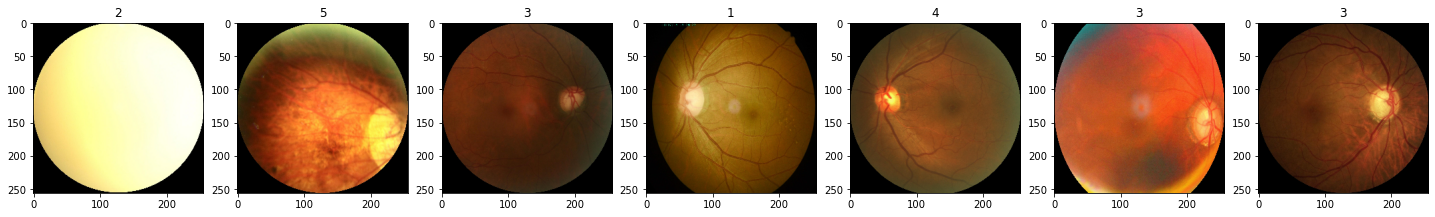

In [94]:
fig, ax = plt.subplots(ncols=7,figsize=(25,25))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [95]:
# Training, Validation, and Testing datasets
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
print('Training Size:',train_size)
print('Validation Size:',val_size)
print('Testing Size:',test_size)


Training Size: 28
Validation Size: 8
Testing Size: 4


In [96]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building a Deep Neural Network
Conv2D is the layering tool that will create a Convolutional Neural Network with channels and kernel that will reduce the image's feature dimensions, to allow faster runtime.

In [97]:
from tensorflow.keras.models import Sequential # Model Build API, can also use Functional API
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Creating the Model with Relu and Gotta love Layers.
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D()) # Cuts the image in half each time.

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [98]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 32)      

### Training the Model

In [100]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [101]:
history = model.fit(train,epochs=25,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/25
28/28 [==============================] - 23s 762ms/step - loss: 2.0137 - accuracy: 0.1752 - val_loss: 1.8664 - val_accuracy: 0.2188
Epoch 2/25
28/28 [==============================] - 22s 774ms/step - loss: 1.8479 - accuracy: 0.2589 - val_loss: 1.6972 - val_accuracy: 0.3008
Epoch 3/25
28/28 [==============================] - 22s 775ms/step - loss: 1.6938 - accuracy: 0.3527 - val_loss: 1.6142 - val_accuracy: 0.3789
Epoch 4/25
28/28 [==============================] - 23s 780ms/step - loss: 1.6188 - accuracy: 0.3884 - val_loss: 1.4663 - val_accuracy: 0.4570
Epoch 5/25
28/28 [==============================] - 23s 779ms/step - loss: 1.5043 - accuracy: 0.4241 - val_loss: 1.3690 - val_accuracy: 0.5273
Epoch 6/25
28/28 [==============================] - 23s 777ms/step - loss: 1.4187 - accuracy: 0.4688 - val_loss: 1.4252 - val_accuracy: 0.5000
Epoch 7/25
28/28 [==============================] - 23s 790ms/step - loss: 1.3977 - accuracy: 0.4944 - val_loss: 1.2658 - val_accuracy: 0.5508

### Data Visualization and Evaluation

In [102]:
history.history

{'loss': [2.0136938095092773,
  1.8479474782943726,
  1.6938201189041138,
  1.6188396215438843,
  1.5042612552642822,
  1.418676495552063,
  1.3976593017578125,
  1.2528303861618042,
  1.261209487915039,
  1.1287330389022827,
  1.0903788805007935,
  1.007102370262146,
  0.9603659510612488,
  0.8555640578269958,
  0.8559956550598145,
  0.788659393787384,
  0.7252163290977478,
  0.7392925024032593,
  0.6210519075393677,
  0.5851966738700867,
  0.5311362743377686,
  0.4420926570892334,
  0.41301026940345764,
  0.4338434636592865,
  0.4019368588924408],
 'accuracy': [0.1752232164144516,
  0.2589285671710968,
  0.3526785671710968,
  0.3883928656578064,
  0.4241071343421936,
  0.46875,
  0.4944196343421936,
  0.5390625,
  0.5435267686843872,
  0.5982142686843872,
  0.6015625,
  0.6517857313156128,
  0.6662946343421936,
  0.6897321343421936,
  0.6986607313156128,
  0.7131696343421936,
  0.7310267686843872,
  0.7433035969734192,
  0.78125,
  0.7924107313156128,
  0.8303571343421936,
  0.856026

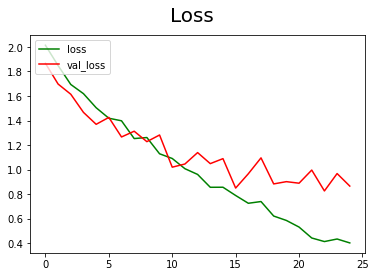

In [103]:
fig= plt.figure()
plt.plot(history.history['loss'],color='green',label='loss')
plt.plot(history.history['val_loss'],color='red',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

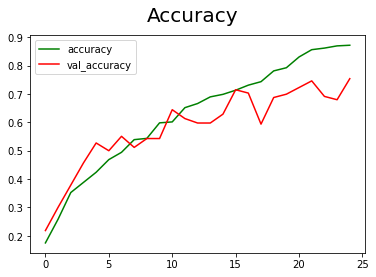

In [104]:
fig= plt.figure()
plt.plot(history.history['accuracy'],color='green',label='accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Saving the CNN model into a h5

<function matplotlib.pyplot.show(close=None, block=None)>

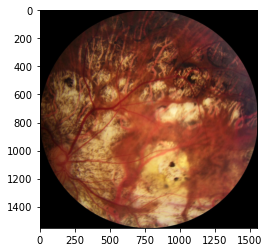

In [105]:
import cv2
img = cv2.imread('C:\\Users\\David\\OneDrive\\Documents\\GitHub\\Capstone_Project\\Training_Images\\myopia\\741_left.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show

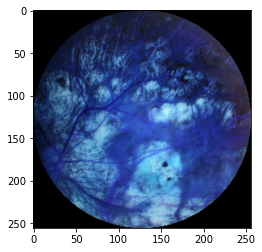

In [106]:
# This style of imaging will be handed in another CNN model later on.
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [107]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [111]:
yhat = model.predict(np.expand_dims(resize/255,0 ))

1/1 [==============================] - 0s 20ms/step


In [112]:
yhat.argmax()

2

The spot in the array with the highest number is 4, which is Myopia and that is correct.

### Testing and Saving

In [116]:
import cv2
import h5py
from tensorflow.keras.models import load_model
resize = tf.image.resize(img,(256,256))
np.expand_dims(resize,0).shape


(1, 256, 256, 3)

In [118]:
# if this is ran too many times, it could cause a overpacking retracing error.
#model.save(os.path.join("C:\\Users\\David\\OneDrive\\Documents\\GitHub\\Capstone_Project","CNN.h5"))

In [119]:
new_model = load_model(os.path.join("C:\\Users\\David\\OneDrive\\Documents\\GitHub\\Capstone_Project","CNN.h5"))
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 48ms/step


In [120]:
# 7 classifications
if yhatnew.argmax == 0:
    print(f'Predicted class is Abnormal')
elif yhatnew.argmax == 1:
    print(f'Predicted class is Age Mactular Degeneration')
elif yhatnew.argmax == 2:
    print(f'Predicted class is Cataract')
elif yhatnew.argmax == 3:
    print(f'Predicted class is Glaucoma') 
elif yhatnew.argmax == 4:
    print(f'Predicted class is Hypertension')
elif yhatnew.argmax == 5:
    print(f'Predicted class is Myopia')
else:
    print(f'Predicted class is Normal')  

Predicted class is Normal
